# Фреймворк PyTorch для разработки искусственных нейронных сетей
# Урок 5. Рекурентные сети для обработки последовательностей

# <font color='red'>Практическое задание</font>

- Обучить GRU, LSTM для предсказания временного ряда на примере https://www.kaggle.com/c/favorita-grocery-sales-forecasting (для каждого типа продуктов)

Выполнил ___Соковнин ИЛ___

In [ ]:
import numpy
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [1]:
import os, sys
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# PATH_DATA = '/content/drive/lesson5/data/'
PATH_DATA = '.\\data\\'
print(PATH_DATA)

.\data\


In [ ]:
%%time

train = pd.read_csv(PATH_DATA + "train.csv", sep=",")
print(train.shape)
# train = train.set_index('id')
train.head(3)

In [ ]:
train.info()

In [3]:
# функция для оптимизации использования памяти
def reduce_memory(df): 
    """Снижает размерности строк"""

    float_cols = df.select_dtypes(include=['float']).columns
    int_cols = df.select_dtypes(include=['int64']).columns
    
    df[float_cols] = df[float_cols].astype('float32')
    df[int_cols] = df[int_cols].astype('int32')
    
    return df

In [4]:
reduce_memory(train)
train.info()

In [ ]:
train_dt = train[['date', 'store_nbr', 'unit_sales']]
train_dt.info()
# train_dt.info(memory_usage='deep')
train_dt.head(3)

In [ ]:
%%time

train_dt.to_csv(PATH_DATA + 'train_dt.csv', index=False) 

In [ ]:
# del (train_dt)
# del(train)

# Освобождаем память
import gc
gc.collect()
gc.collect() # два раза подряд, для надёжности

In [2]:
%%time

train_dt = pd.read_csv(PATH_DATA + "train_dt.csv", sep=",")
print(train_dt.shape)
train_dt.info()
train_dt.head(3)

(125497040, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125497040 entries, 0 to 125497039
Data columns (total 3 columns):
 #   Column      Dtype  
---  ------      -----  
 0   date        object 
 1   store_nbr   int64  
 2   unit_sales  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.8+ GB
Wall time: 33.2 s


,date,store_nbr,unit_sales
0,2013-01-01,25,7.0
1,2013-01-01,25,1.0
2,2013-01-01,25,2.0


### Data processing
Subseting, join and aggregating data

In [6]:
stores = pd.read_csv(PATH_DATA + "stores.csv") 

In [9]:
%%time

t=train_dt.groupby(['store_nbr','date'], as_index=False).agg({"unit_sales": "sum"})
train = pd.merge(t, stores, how='left', on=['store_nbr'])
mask=train['state']=='Pichincha'
train=train.loc[mask]
train=train.groupby(['date'], as_index=False).agg({"unit_sales": "sum"})

Wall time: 125 ms


### Sales for Pichincha state (train data)

In [23]:
print(train.shape)
train.info()
train.tail(12)

(1679, 2)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1679 entries, 0 to 1678
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1679 non-null   object 
 1   unit_sales  1679 non-null   float32
dtypes: float32(1), object(1)
memory usage: 32.8+ KB


,date,unit_sales
1667,2017-08-04,425713.15625
1668,2017-08-05,500614.56250
1669,2017-08-06,547592.12500
1670,2017-08-07,396073.43750
1671,2017-08-08,347288.25000
1672,2017-08-09,367813.87500
1673,2017-08-10,315940.31250
1674,2017-08-11,406504.40625
1675,2017-08-12,389945.59375
1676,2017-08-13,438714.53125


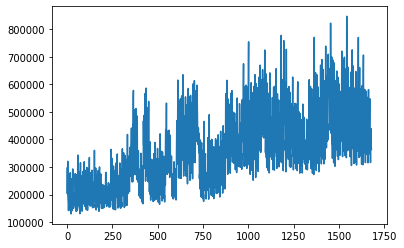

In [24]:
import matplotlib.pyplot as plt

plt.plot(train['unit_sales'])
plt.show()

There is a trend over time especially for the 2015 year, by 2015 and 2016 the slope gets lower and loses trend. It’s easy to recognize how the sales increasing over the last quarters.

In [25]:
# Сохраняем результат в файл
train.to_csv(PATH_DATA + 'train_data.csv', index=False) 

### Загрузка подготовленных данных

In [5]:
train = pd.read_csv(PATH_DATA + "train_data.csv", sep=",")
print(train.shape)
train.info()
train.head(3)

(1679, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1679 entries, 0 to 1678
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1679 non-null   object 
 1   unit_sales  1679 non-null   float64
dtypes: float64(1), object(1)
memory usage: 26.4+ KB


,date,unit_sales
0,2013-01-02,295729.00
1,2013-01-03,203589.56
2,2013-01-04,203090.77


### Разделение выборки для обучающих и тестовых данных

In [6]:
train_size = int(len(train) * 0.75)
test_size = len(train) - train_size

print(train_size,test_size, len(train))

1259 420 1679


In [7]:
train1= train[0:train_size]
test =  train[train_size:len(train)]
print(len(train1), len(test))

1259 420


In [8]:
train1=train1.set_index("date")
test=test.set_index("date")
train=train.set_index("date")
train1=train1.values
test=test.values
train=train.values

Determine the number of previous time steps to use as input variables to predict the next time period. In this case (look_back) determinated to 1

In [9]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [11]:
# import numpy

look_back = 1
trainX, trainY = create_dataset(train1, look_back)
testX, testY = create_dataset(test, look_back)

In [19]:
trainX.shape, trainY.shape

((1257, 1), (1257,))

Multilayer Perceptron model
A simple network with 1 input (look_back) , 1 hidden layer with 8 neurons and one (1) output layer.

In [14]:
model = Sequential()
model.add(Dense(8, input_dim=look_back, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=200, batch_size=2, verbose=2)

Epoch 1/200
629/629 - 5s - loss: 14533445632.0000 - 5s/epoch - 7ms/step
Epoch 2/200
629/629 - 2s - loss: 7524797440.0000 - 2s/epoch - 2ms/step
Epoch 3/200
629/629 - 1s - loss: 7560857088.0000 - 1s/epoch - 2ms/step
Epoch 4/200
629/629 - 1s - loss: 7531424256.0000 - 1s/epoch - 2ms/step
Epoch 5/200
629/629 - 2s - loss: 7566036480.0000 - 2s/epoch - 2ms/step
Epoch 6/200
629/629 - 2s - loss: 7550424576.0000 - 2s/epoch - 2ms/step
Epoch 7/200
629/629 - 2s - loss: 7579824128.0000 - 2s/epoch - 2ms/step
Epoch 8/200
629/629 - 2s - loss: 7572335616.0000 - 2s/epoch - 2ms/step
Epoch 9/200
629/629 - 1s - loss: 7573846016.0000 - 1s/epoch - 2ms/step
Epoch 10/200
629/629 - 1s - loss: 7536196608.0000 - 1s/epoch - 2ms/step
Epoch 11/200
629/629 - 1s - loss: 7586246144.0000 - 1s/epoch - 2ms/step
Epoch 12/200
629/629 - 1s - loss: 7436213248.0000 - 1s/epoch - 2ms/step
Epoch 13/200
629/629 - 1s - loss: 7567697408.0000 - 1s/epoch - 2ms/step
Epoch 14/200
629/629 - 1s - loss: 7576020992.0000 - 1s/epoch - 2ms/step


Epoch 115/200
629/629 - 2s - loss: 7565471744.0000 - 2s/epoch - 2ms/step
Epoch 116/200
629/629 - 2s - loss: 7562579456.0000 - 2s/epoch - 3ms/step
Epoch 117/200
629/629 - 2s - loss: 7551458304.0000 - 2s/epoch - 2ms/step
Epoch 118/200
629/629 - 2s - loss: 7580190720.0000 - 2s/epoch - 3ms/step
Epoch 119/200
629/629 - 2s - loss: 7553456640.0000 - 2s/epoch - 2ms/step
Epoch 120/200
629/629 - 2s - loss: 7548702208.0000 - 2s/epoch - 3ms/step
Epoch 121/200
629/629 - 1s - loss: 7530082816.0000 - 1s/epoch - 2ms/step
Epoch 122/200
629/629 - 2s - loss: 7566064128.0000 - 2s/epoch - 2ms/step
Epoch 123/200
629/629 - 2s - loss: 7561574400.0000 - 2s/epoch - 2ms/step
Epoch 124/200
629/629 - 2s - loss: 7510500352.0000 - 2s/epoch - 2ms/step
Epoch 125/200
629/629 - 2s - loss: 7554005504.0000 - 2s/epoch - 2ms/step
Epoch 126/200
629/629 - 2s - loss: 7535081472.0000 - 2s/epoch - 3ms/step
Epoch 127/200
629/629 - 2s - loss: 7564379648.0000 - 2s/epoch - 2ms/step
Epoch 128/200
629/629 - 2s - loss: 7529616384.0000 

### 

In [16]:
trainScore = model.evaluate(trainX, trainY, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
testScore = model.evaluate(testX, testY, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

Train Score: 7544227328.00 MSE (86857.51 RMSE)
Test Score: 13193974784.00 MSE (114865.03 RMSE)


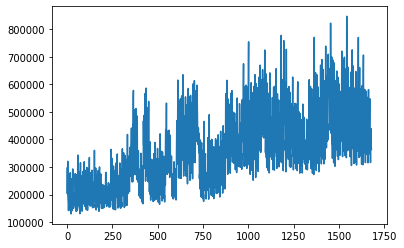

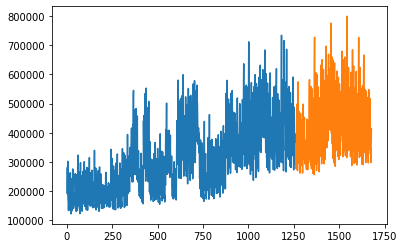

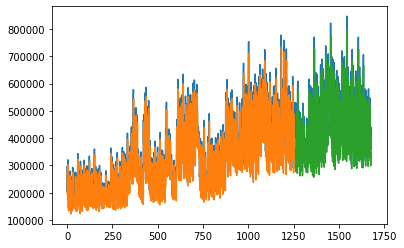

In [17]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
 
trainPredictPlot = numpy.empty_like(train)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
 
testPredictPlot = numpy.empty_like(train)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(train)-1, :] = testPredict
 
plt.plot(train)
plt.show()
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()
plt.plot(train)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()


The average error in the training data is 86.857 units and the averrage in the test data is 114.865 units sold per day

**сеть:  LSTM слои+Conv1D +Dense слой.**

In [ ]:
callbaсk = EarlyStopping(monitor='val_mae', patience=2)

model = Sequential()

model.add(LSTM(64, input_shape = (inputs.shape[1], inputs.shape[2]), return_sequences="True"))
model.add(LSTM(64, return_sequences="True")) # <None, 3,32>
model.add(Conv1D(64, 3, activation="linear")) #(None,3,64)
#model.add(Conv1D(64, 1, activation="linear"))
model.add(Flatten())                          # (None, 3*64)
model.add(Dense(3, activation="linear"))      # (None,3)

model.add(Dense(1, activation="linear"))

model.compile(loss="mse", optimizer="adam", metrics=['mae'])

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[callbaсk, tensorboard_callback])


plt.plot(history.history['mae'][1:], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'][1:], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

Все параметры класса RNN<br>
Приведём список всех параметров класса RNN в фреймворке PyTorch:<br>
nn.RNN<br>
__… (input_size, hidden_size, num_layers=1, nonlinearity='tanh', bias=True, … batch_first=False, dropout=0, bidirectional=False) [doc]__

Отметим не упомянутый ранее параметр dropout. По умолчанию он равен нулю. При ненулевом значении, после каждого слоя (num_layers > 1), кроме последнего, вставляется слой dropout, который с вероятностью dropout случайно "отключает" (делает нулевыми) часть элементов тензоров на выходах каждой ячейке.

Установка параметра bias в значение False ликвидирует вектор смещения после перемножения матриц.

In [ ]:
https://qudata.com/ml/ru/NN_RNN_Torch.html - ML: Рекуррентные сети на PyTorch